# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.stats.diagnostic import acorr_ljungbox, normal_ad
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Forecast

In [2]:
df = pd.read_csv(r"C:\Users\AS\Pictures\buat infog\Arsen 25\data harga rumah jadi.csv")
df

,Unnamed: 0,tanggal,indeks harga rumah
0,0,2002-03-01,73.906
1,3,2002-06-01,75.029
2,6,2002-09-01,76.138
3,9,2002-12-01,76.818
4,12,2003-03-01,78.554
...,...,...,...
86,258,2023-09-01,163.915
87,261,2023-12-01,164.341
88,264,2024-03-01,165.268
89,267,2024-06-01,165.860


In [3]:
df = df.drop(['Unnamed: 0'], axis=1)
df

,tanggal,indeks harga rumah
0,2002-03-01,73.906
1,2002-06-01,75.029
2,2002-09-01,76.138
3,2002-12-01,76.818
4,2003-03-01,78.554
...,...,...
86,2023-09-01,163.915
87,2023-12-01,164.341
88,2024-03-01,165.268
89,2024-06-01,165.860


In [4]:
df.isna().sum()

tanggal               0
indeks harga rumah    0
dtype: int64

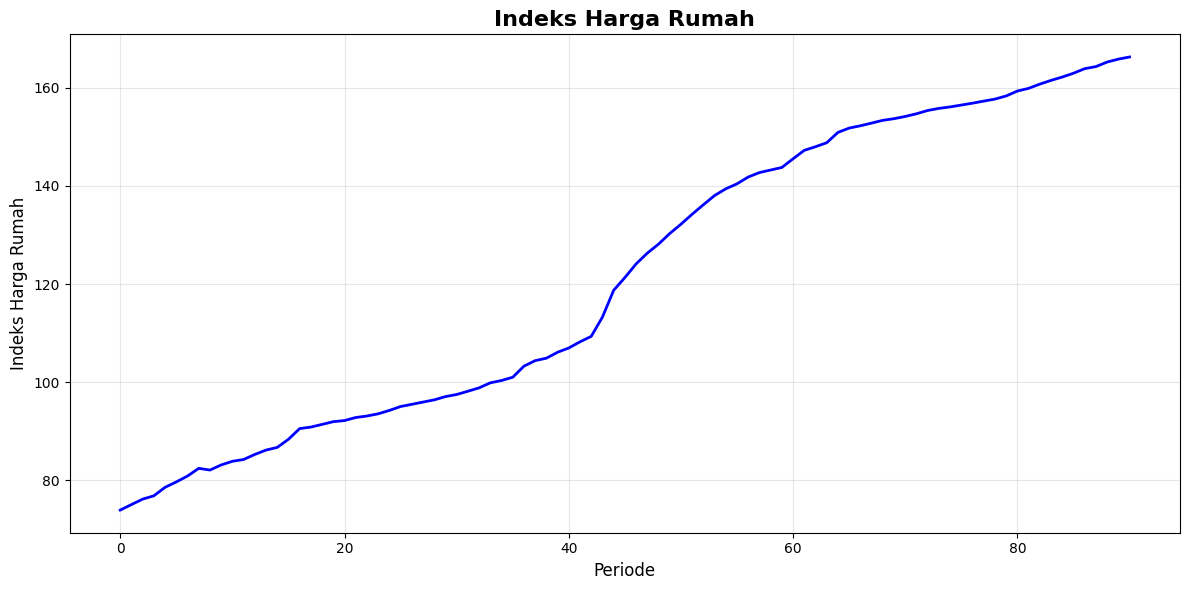

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['indeks harga rumah'], linewidth=2, color='blue')
plt.title('Indeks Harga Rumah', fontsize=16, fontweight='bold')
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Indeks Harga Rumah', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## DMA

Train data: 72 points
Test data: 19 points
Train MAPE: 4.03%
Test MAPE: 1.85%


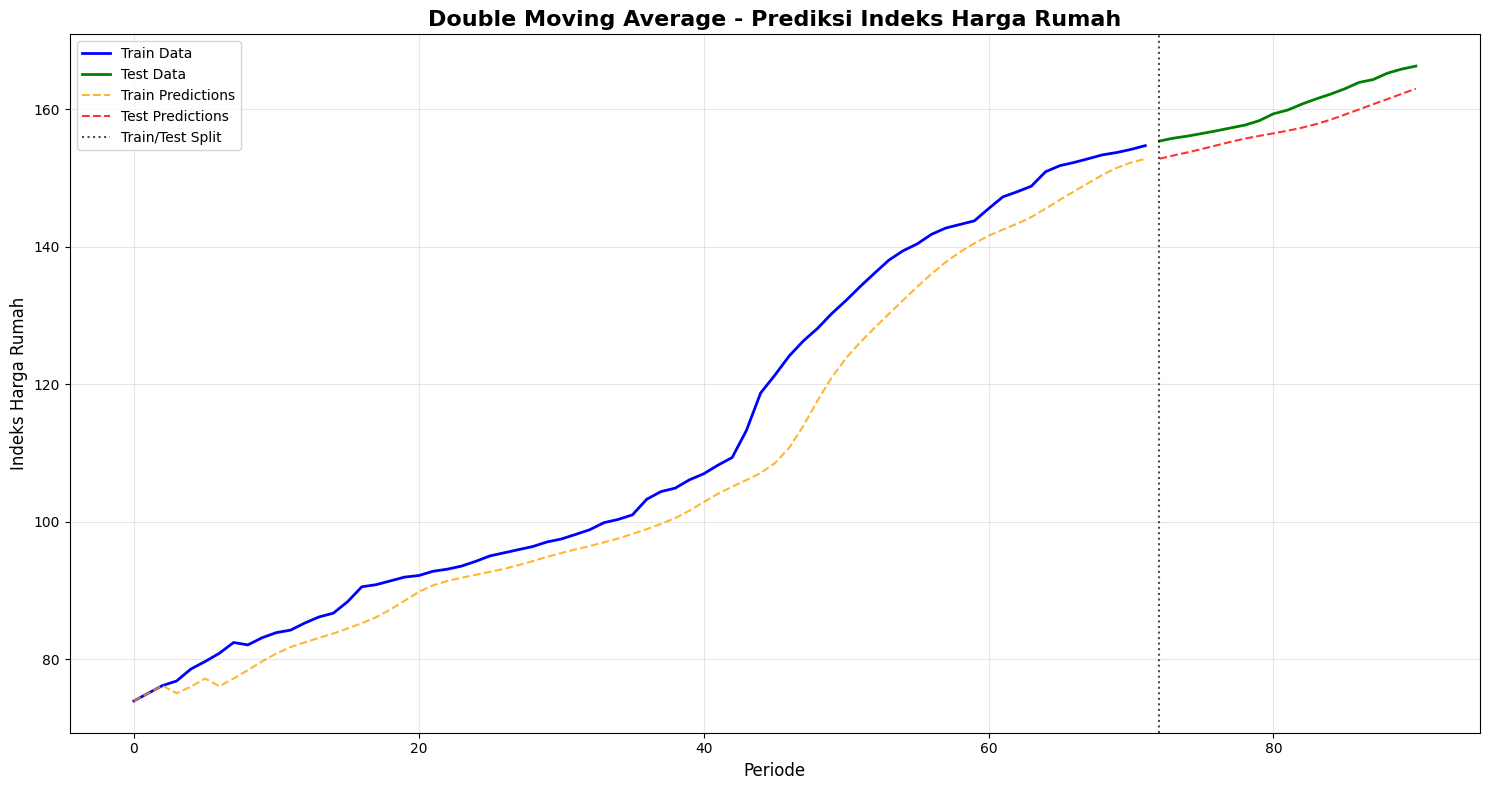

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

data = df['indeks harga rumah'].values
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Train data: {len(train_data)} points")
print(f"Test data: {len(test_data)} points")

def double_moving_average(data, n1=3, n2=3):
    predictions = []
    
    for i in range(len(data)):
        if i < n1:
            predictions.append(data[i])
        elif i < n1 + n2:
            ma1 = np.mean(data[max(0, i-n1):i])
            predictions.append(ma1)
        else:
            ma1_values = []
            for j in range(i-n2, i):
                if j >= n1:
                    ma1 = np.mean(data[max(0, j-n1):j])
                    ma1_values.append(ma1)
            
            if ma1_values:
                ma2 = np.mean(ma1_values)
                predictions.append(ma2)
            else:
                predictions.append(data[i-1])
    
    return np.array(predictions)

train_predictions = double_moving_average(train_data, n1=3, n2=3)

test_predictions = []
extended_data = np.concatenate([train_data, test_data])

for i in range(len(train_data), len(extended_data)):
    available_data = extended_data[:i]
    pred = double_moving_average(available_data, n1=3, n2=3)
    test_predictions.append(pred[-1])

test_predictions = np.array(test_predictions)

train_mape = mean_absolute_percentage_error(train_data[6:], train_predictions[6:]) * 100
test_mape = mean_absolute_percentage_error(test_data, test_predictions) * 100

print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")

plt.figure(figsize=(15, 8))
plt.plot(range(len(train_data)), train_data, label='Train Data', color='blue', linewidth=2)
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data', color='green', linewidth=2)
plt.plot(range(len(train_data)), train_predictions, label='Train Predictions', color='orange', linestyle='--', alpha=0.8)
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_predictions, label='Test Predictions', color='red', linestyle='--', alpha=0.8)
plt.axvline(x=len(train_data), color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
plt.title('Double Moving Average - Prediksi Indeks Harga Rumah', fontsize=16, fontweight='bold')
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Indeks Harga Rumah', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## DES

Train data: 72 points
Test data: 19 points
Train MAPE: 0.45%
Test MAPE: 0.46%
Alpha (level): 1.0000
Beta (trend): 0.4661


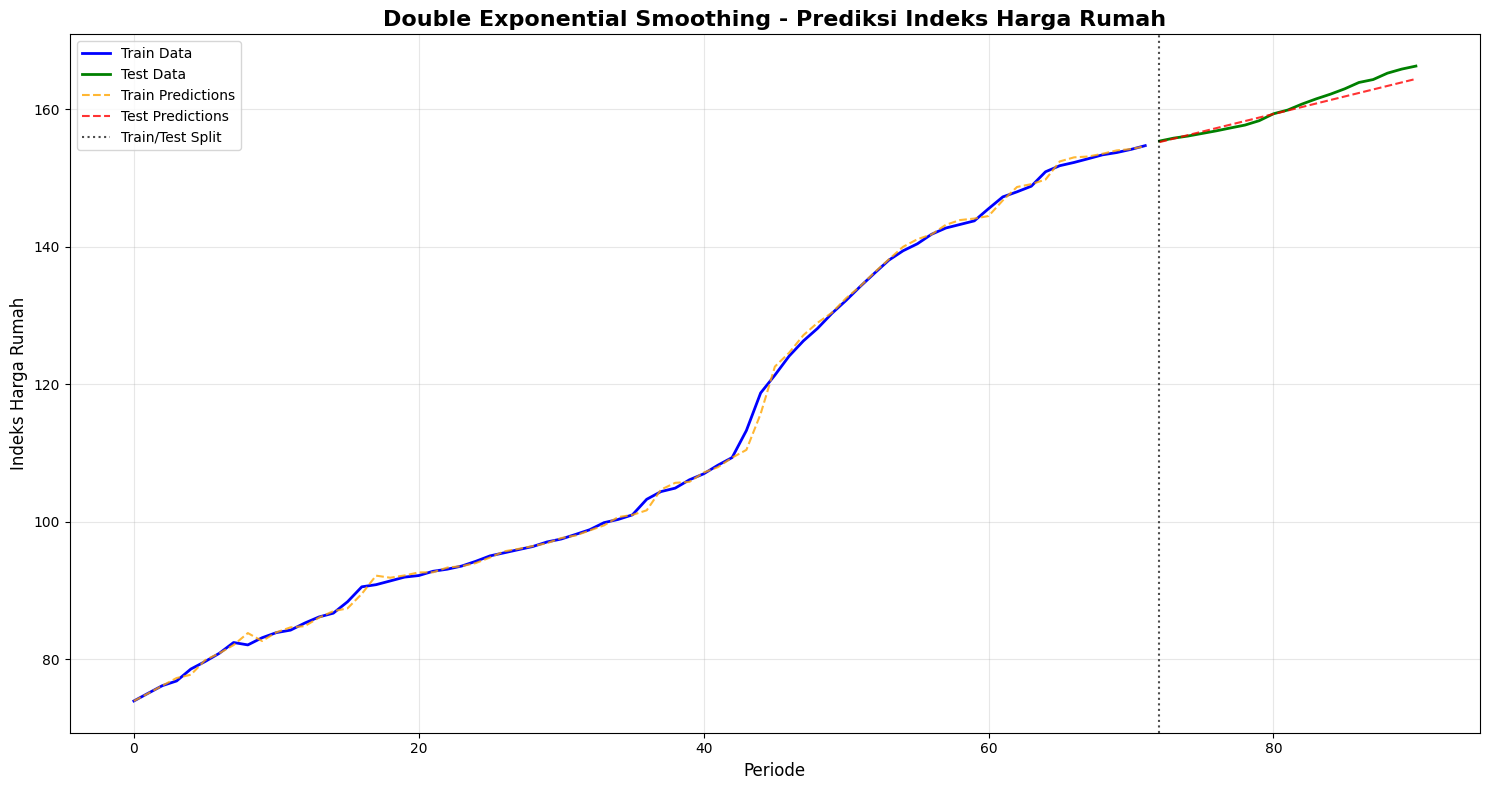

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

data = df['indeks harga rumah'].values
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Train data: {len(train_data)} points")
print(f"Test data: {len(test_data)} points")

model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
fitted_model = model.fit()

train_predictions = fitted_model.fittedvalues
test_predictions = fitted_model.forecast(steps=len(test_data))

train_mape = mean_absolute_percentage_error(train_data[1:], train_predictions[1:]) * 100
test_mape = mean_absolute_percentage_error(test_data, test_predictions) * 100

print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")

print(f"Alpha (level): {fitted_model.params['smoothing_level']:.4f}")
print(f"Beta (trend): {fitted_model.params['smoothing_trend']:.4f}")

plt.figure(figsize=(15, 8))
plt.plot(range(len(train_data)), train_data, label='Train Data', color='blue', linewidth=2)
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data', color='green', linewidth=2)
plt.plot(range(len(train_data)), train_predictions, label='Train Predictions', color='orange', linestyle='--', alpha=0.8)
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_predictions, label='Test Predictions', color='red', linestyle='--', alpha=0.8)
plt.axvline(x=len(train_data), color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
plt.title('Double Exponential Smoothing - Prediksi Indeks Harga Rumah', fontsize=16, fontweight='bold')
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Indeks Harga Rumah', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## DES Grid Search

Train data: 72 points
Test data: 19 points

Best Parameters:
Trend: mul
Damped: False
Alpha: 0.9
Beta: 0.3
Best Test MAPE: 0.28%

Best Model Performance:
Train MAPE: 0.47%
Test MAPE: 0.28%

Top 5 Best Models:
1. Trend: mul, Damped: False, Alpha: 0.9, Beta: 0.3, MAPE: 0.28%
2. Trend: mul, Damped: False, Alpha: 0.7, Beta: 0.3, MAPE: 0.30%
3. Trend: add, Damped: False, Alpha: 0.9, Beta: 0.3, MAPE: 0.32%
4. Trend: mul, Damped: False, Alpha: 0.5, Beta: 0.3, MAPE: 0.34%
5. Trend: mul, Damped: False, Alpha: 0.9, Beta: 0.9, MAPE: 0.36%


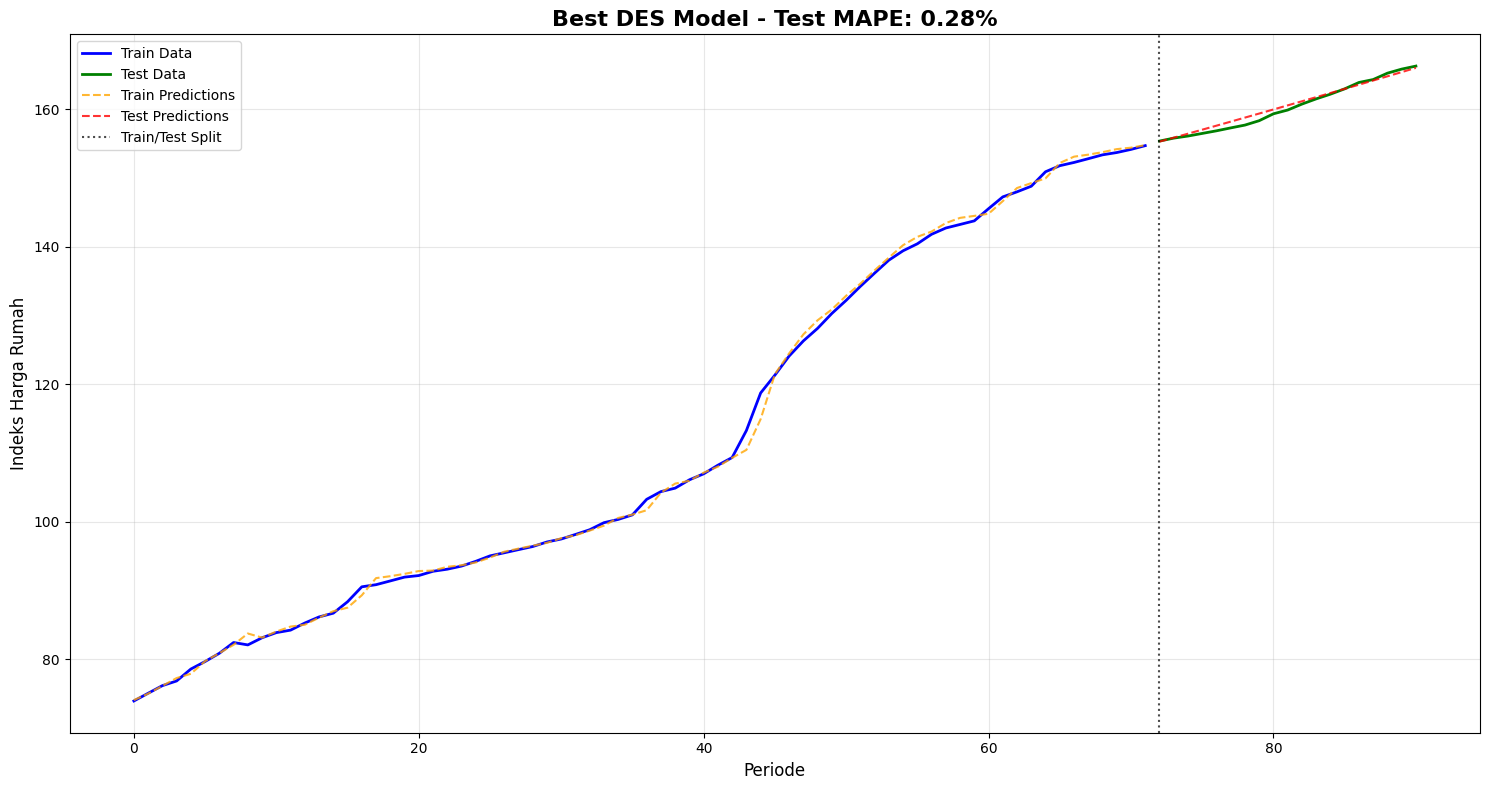

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import itertools

data = df['indeks harga rumah'].values
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Train data: {len(train_data)} points")
print(f"Test data: {len(test_data)} points")

alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
beta_values = [0.1, 0.3, 0.5, 0.7, 0.9]
trend_types = ['add', 'mul']
damped_options = [True, False]

best_params = {}
best_mape = float('inf')
results = []

for trend in trend_types:
    for damped in damped_options:
        for alpha in alpha_values:
            for beta in beta_values:
                try:
                    model = ExponentialSmoothing(
                        train_data, 
                        trend=trend, 
                        damped_trend=damped,
                        seasonal=None
                    )
                    
                    fitted_model = model.fit(
                        smoothing_level=alpha,
                        smoothing_trend=beta,
                        optimized=False
                    )
                    
                    test_pred = fitted_model.forecast(steps=len(test_data))
                    test_mape = mean_absolute_percentage_error(test_data, test_pred) * 100
                    
                    results.append({
                        'trend': trend,
                        'damped': damped,
                        'alpha': alpha,
                        'beta': beta,
                        'test_mape': test_mape,
                        'model': fitted_model
                    })
                    
                    if test_mape < best_mape:
                        best_mape = test_mape
                        best_params = {
                            'trend': trend,
                            'damped': damped,
                            'alpha': alpha,
                            'beta': beta,
                            'test_mape': test_mape,
                            'model': fitted_model
                        }
                        
                except:
                    continue

print(f"\nBest Parameters:")
print(f"Trend: {best_params['trend']}")
print(f"Damped: {best_params['damped']}")
print(f"Alpha: {best_params['alpha']}")
print(f"Beta: {best_params['beta']}")
print(f"Best Test MAPE: {best_params['test_mape']:.2f}%")

best_model = best_params['model']
train_predictions = best_model.fittedvalues
test_predictions = best_model.forecast(steps=len(test_data))

train_mape = mean_absolute_percentage_error(train_data[1:], train_predictions[1:]) * 100

print(f"\nBest Model Performance:")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {best_params['test_mape']:.2f}%")

sorted_results = sorted(results, key=lambda x: x['test_mape'])
print(f"\nTop 5 Best Models:")
for i, result in enumerate(sorted_results[:5], 1):
    print(f"{i}. Trend: {result['trend']}, Damped: {result['damped']}, "
          f"Alpha: {result['alpha']}, Beta: {result['beta']}, "
          f"MAPE: {result['test_mape']:.2f}%")

plt.figure(figsize=(15, 8))
plt.plot(range(len(train_data)), train_data, label='Train Data', color='blue', linewidth=2)
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data', color='green', linewidth=2)
plt.plot(range(len(train_data)), train_predictions, label='Train Predictions', color='orange', linestyle='--', alpha=0.8)
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_predictions, label='Test Predictions', color='red', linestyle='--', alpha=0.8)
plt.axvline(x=len(train_data), color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
plt.title(f'Best DES Model - Test MAPE: {best_params["test_mape"]:.2f}%', fontsize=16, fontweight='bold')
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Indeks Harga Rumah', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Model Parameters:
Trend: mul
Damped: False
Alpha: 0.9
Beta: 0.3

Model Performance:
Train MAPE: 0.47%
Test MAPE: 0.28%

Prediksi 9 Langkah ke Depan:
Langkah 1: 166.66
Langkah 2: 167.28
Langkah 3: 167.90
Langkah 4: 168.52
Langkah 5: 169.15
Langkah 6: 169.78
Langkah 7: 170.41
Langkah 8: 171.05
Langkah 9: 171.68


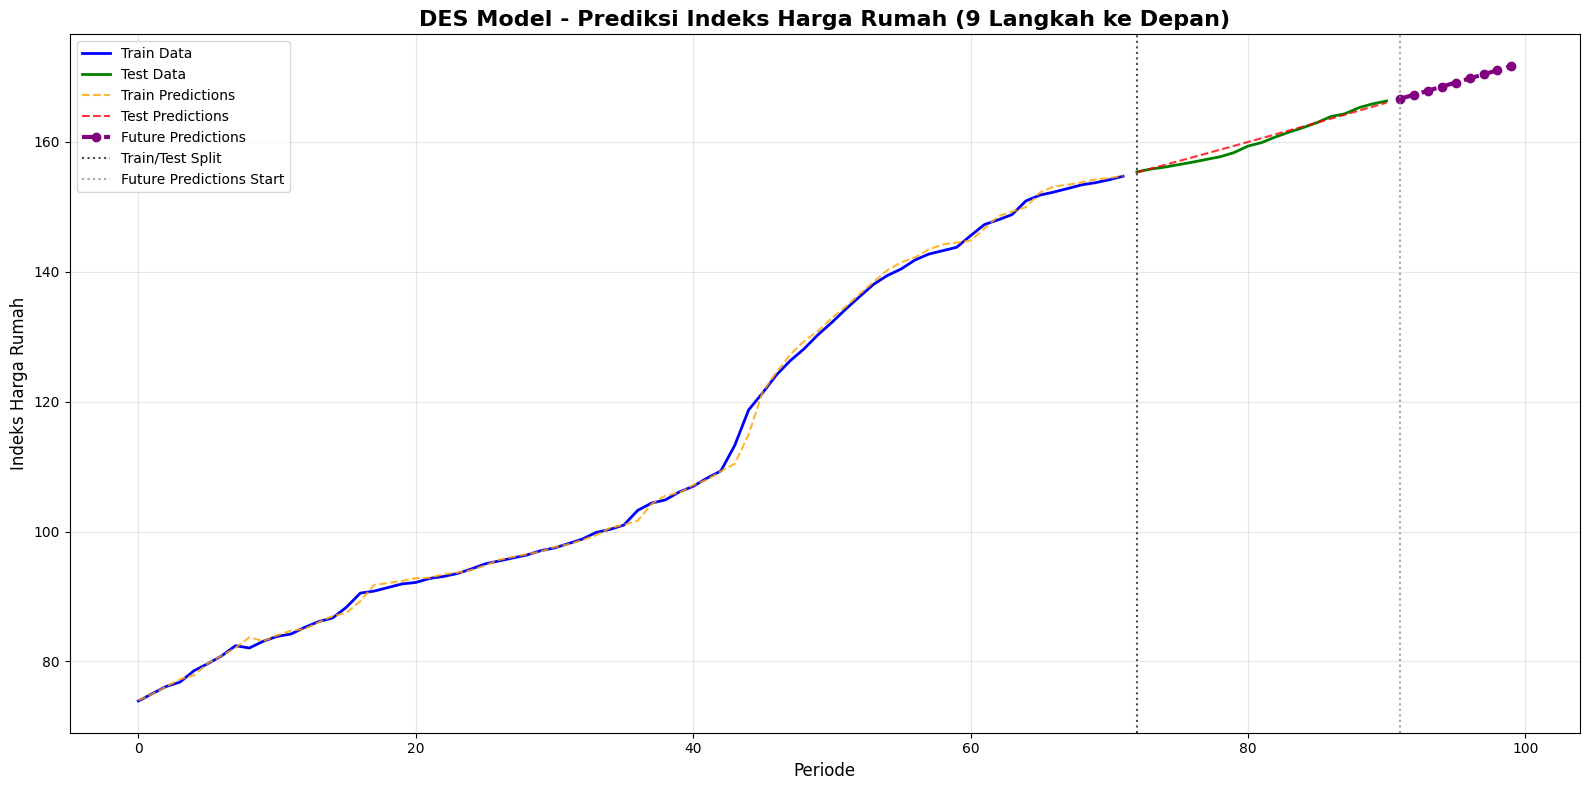


Ringkasan Prediksi Future:
Rata-rata prediksi 9 langkah: 169.16
Nilai minimum prediksi: 166.66
Nilai maksimum prediksi: 171.68


In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

data = df['indeks harga rumah'].values
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

model = ExponentialSmoothing(
    train_data, 
    trend='mul', 
    damped_trend=False,
    seasonal=None
)

fitted_model = model.fit(
    smoothing_level=0.9,
    smoothing_trend=0.3,
    optimized=False
)

train_predictions = fitted_model.fittedvalues
test_predictions = fitted_model.forecast(steps=len(test_data))
future_predictions = fitted_model.forecast(steps=len(test_data) + 9)

future_steps = future_predictions[-9:]

train_mape = mean_absolute_percentage_error(train_data[1:], train_predictions[1:]) * 100
test_mape = mean_absolute_percentage_error(test_data, test_predictions) * 100

print(f"Model Parameters:")
print(f"Trend: mul")
print(f"Damped: False")
print(f"Alpha: 0.9")
print(f"Beta: 0.3")
print(f"\nModel Performance:")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")

print(f"\nPrediksi 9 Langkah ke Depan:")
for i, pred in enumerate(future_steps, 1):
    print(f"Langkah {i}: {pred:.2f}")

plt.figure(figsize=(16, 8))
total_len = len(train_data) + len(test_data)
future_len = 9

plt.plot(range(len(train_data)), train_data, label='Train Data', color='blue', linewidth=2)
plt.plot(range(len(train_data), total_len), test_data, label='Test Data', color='green', linewidth=2)
plt.plot(range(len(train_data)), train_predictions, label='Train Predictions', color='orange', linestyle='--', alpha=0.8)
plt.plot(range(len(train_data), total_len), test_predictions, label='Test Predictions', color='red', linestyle='--', alpha=0.8)
plt.plot(range(total_len, total_len + future_len), future_steps, label='Future Predictions', color='purple', linestyle='--', linewidth=3, marker='o')

plt.axvline(x=len(train_data), color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
plt.axvline(x=total_len, color='gray', linestyle=':', alpha=0.7, label='Future Predictions Start')

plt.title('DES Model - Prediksi Indeks Harga Rumah (9 Langkah ke Depan)', fontsize=16, fontweight='bold')
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Indeks Harga Rumah', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nRingkasan Prediksi Future:")
print(f"Rata-rata prediksi 9 langkah: {np.mean(future_steps):.2f}")
print(f"Nilai minimum prediksi: {np.min(future_steps):.2f}")
print(f"Nilai maksimum prediksi: {np.max(future_steps):.2f}")

Data Gabungan (10 baris pertama):
   Periode  Indeks_Harga_Rumah_Aktual  Type_x  Indeks_Harga_Rumah_Prediksi  \
0        0                     73.906  Actual                    74.035582   
1        1                     75.029  Actual                    74.967955   
2        2                     76.138  Actual                    76.104287   
3        3                     76.818  Actual                    77.241282   
4        4                     78.554  Actual                    77.862155   
5        5                     79.648  Actual                    79.698562   
6        6                     80.846  Actual                    80.871015   
7        7                     82.415  Actual                    82.077884   
8        8                     82.065  Actual                    83.726725   
9        9                     83.107  Actual                    83.126310   

             Type_y Status  
0  Train_Prediction  Train  
1  Train_Prediction  Train  
2  Train_Prediction 

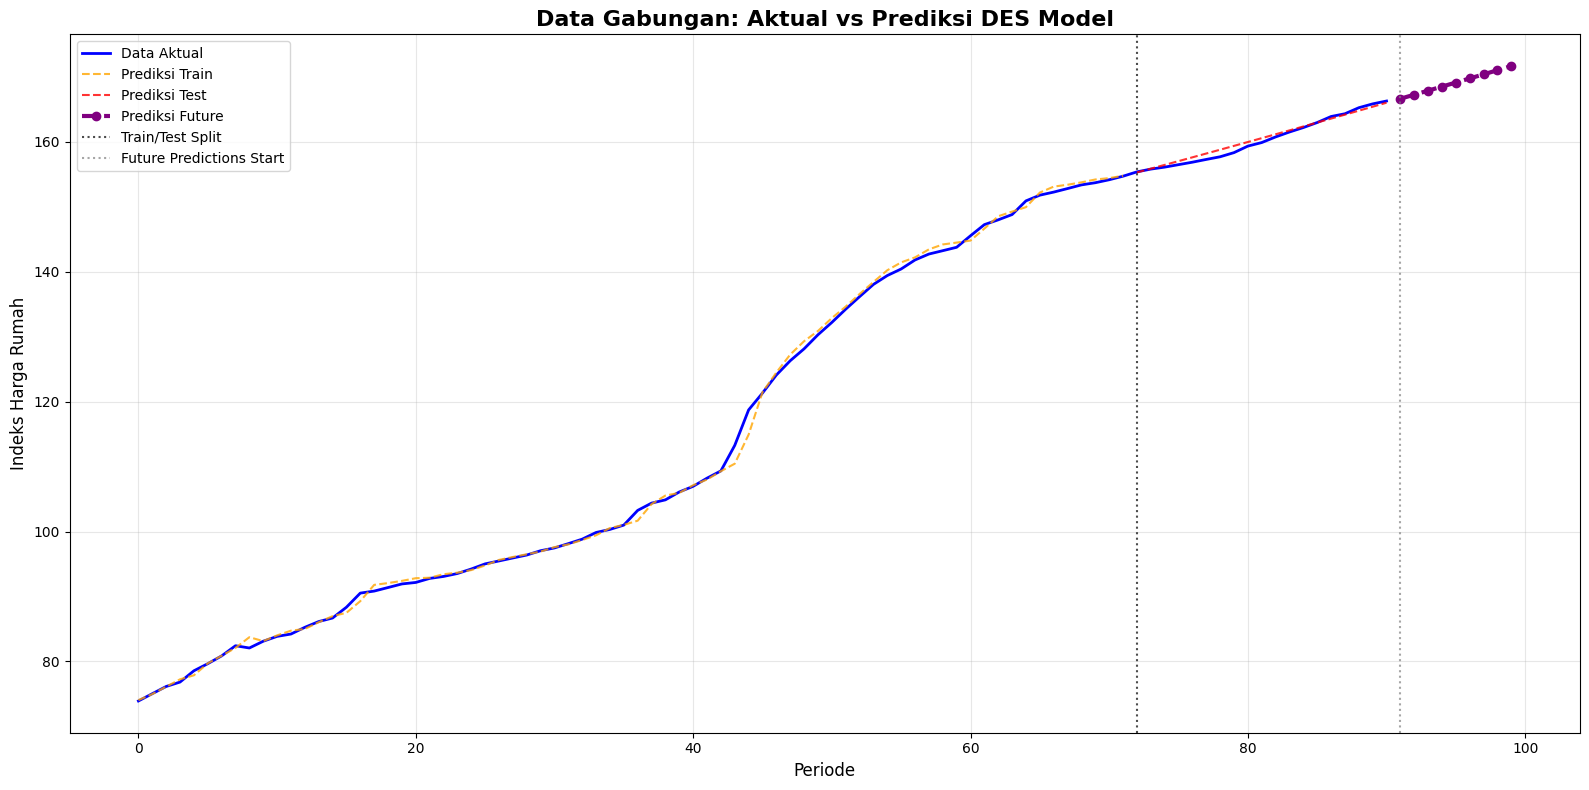


Data gabungan berhasil dibuat dengan 100 baris


In [10]:
# Gabungkan data hasil prediksi dengan data aktual
import pandas as pd

# Buat DataFrame untuk data aktual
actual_data = pd.DataFrame({
    'Periode': range(len(data)),
    'Indeks_Harga_Rumah_Aktual': data,
    'Type': ['Actual'] * len(data)
})

# Buat DataFrame untuk prediksi training
train_pred_data = pd.DataFrame({
    'Periode': range(len(train_predictions)),
    'Indeks_Harga_Rumah_Prediksi': train_predictions,
    'Type': ['Train_Prediction'] * len(train_predictions)
})

# Buat DataFrame untuk prediksi testing
test_pred_data = pd.DataFrame({
    'Periode': range(len(train_data), len(train_data) + len(test_predictions)),
    'Indeks_Harga_Rumah_Prediksi': test_predictions,
    'Type': ['Test_Prediction'] * len(test_predictions)
})

# Buat DataFrame untuk prediksi future
future_pred_data = pd.DataFrame({
    'Periode': range(len(data), len(data) + len(future_steps)),
    'Indeks_Harga_Rumah_Prediksi': future_steps,
    'Type': ['Future_Prediction'] * len(future_steps)
})

# Gabungkan semua data prediksi
all_predictions = pd.concat([train_pred_data, test_pred_data, future_pred_data], ignore_index=True)

# Merge data aktual dengan prediksi berdasarkan periode
combined_data = pd.merge(actual_data, all_predictions, on='Periode', how='outer')

# Isi kolom yang kosong
combined_data['Indeks_Harga_Rumah_Aktual'] = combined_data['Indeks_Harga_Rumah_Aktual'].fillna(0)
combined_data['Indeks_Harga_Rumah_Prediksi'] = combined_data['Indeks_Harga_Rumah_Prediksi'].fillna(0)

# Buat kolom status untuk membedakan data
combined_data['Status'] = combined_data.apply(lambda row: 
    'Train' if row['Periode'] < len(train_data) 
    else 'Test' if row['Periode'] < len(data)
    else 'Future', axis=1)

print("Data Gabungan (10 baris pertama):")
print(combined_data.head(10))

print(f"\nData Gabungan (10 baris terakhir):")
print(combined_data.tail(10))

print(f"\nRingkasan Data:")
print(f"Total periode: {len(combined_data)}")
print(f"Data train: {len(combined_data[combined_data['Status'] == 'Train'])}")
print(f"Data test: {len(combined_data[combined_data['Status'] == 'Test'])}")
print(f"Data future: {len(combined_data[combined_data['Status'] == 'Future'])}")

# Visualisasi data gabungan
plt.figure(figsize=(16, 8))

# Plot data aktual
actual_mask = combined_data['Indeks_Harga_Rumah_Aktual'] > 0
plt.plot(combined_data[actual_mask]['Periode'], 
         combined_data[actual_mask]['Indeks_Harga_Rumah_Aktual'], 
         label='Data Aktual', color='blue', linewidth=2)

# Plot prediksi train
train_mask = (combined_data['Status'] == 'Train') & (combined_data['Indeks_Harga_Rumah_Prediksi'] > 0)
plt.plot(combined_data[train_mask]['Periode'], 
         combined_data[train_mask]['Indeks_Harga_Rumah_Prediksi'], 
         label='Prediksi Train', color='orange', linestyle='--', alpha=0.8)

# Plot prediksi test
test_mask = (combined_data['Status'] == 'Test') & (combined_data['Indeks_Harga_Rumah_Prediksi'] > 0)
plt.plot(combined_data[test_mask]['Periode'], 
         combined_data[test_mask]['Indeks_Harga_Rumah_Prediksi'], 
         label='Prediksi Test', color='red', linestyle='--', alpha=0.8)

# Plot prediksi future
future_mask = (combined_data['Status'] == 'Future') & (combined_data['Indeks_Harga_Rumah_Prediksi'] > 0)
plt.plot(combined_data[future_mask]['Periode'], 
         combined_data[future_mask]['Indeks_Harga_Rumah_Prediksi'], 
         label='Prediksi Future', color='purple', linestyle='--', linewidth=3, marker='o')

plt.axvline(x=len(train_data), color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
plt.axvline(x=len(data), color='gray', linestyle=':', alpha=0.7, label='Future Predictions Start')

plt.title('Data Gabungan: Aktual vs Prediksi DES Model', fontsize=16, fontweight='bold')
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Indeks Harga Rumah', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Simpan ke CSV (opsional)
# combined_data.to_csv('data_gabungan_prediksi.csv', index=False)
print(f"\nData gabungan berhasil dibuat dengan {len(combined_data)} baris")

In [ ]:
# combined_data.to_excel("C:/Users/AS/Downloads/data_gabungan_prediksi.xlsx", index=False)

# Clustering

In [2]:
data = pd.read_excel(r"C:/Users/AS/Pictures/buat infog/Arsen 25/DATA LENGKAP MAP CHART.xlsx")
data

,Provinsi,Upah Minimum Regional/Propinsi (Rupiah),Persentase Rumah Tangga yang Memiliki Akses Terhadap Hunian Yang Layak Menurut Provinsi (Persen),AHH
0,ACEH,3165031,63.21,69.975
1,SUMATERA UTARA,2499423,67.44,69.150
2,SUMATERA BARAT,2484041,56.87,69.520
3,RIAU,2888564,68.44,71.650
4,JAMBI,2630162,61.41,71.170
5,SUMATERA SELATAN,3043111,55.25,69.930
6,BENGKULU,2213604,47.94,69.370
7,LAMPUNG,2432002,53.22,70.695
8,KEP. BANGKA BELITUNG,3230024,30.64,70.680
9,KEP. RIAU,3005460,48.19,69.990


In [3]:
# Pisahkan kolom Provinsi dari data numerik
provinsi_col = data['Provinsi']
data_numeric = data.drop('Provinsi', axis=1)

# Lakukan StandardScaler pada data numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numeric)

# Buat DataFrame baru dengan data yang sudah di-scale
data_scaled = pd.DataFrame(X_scaled, columns=data_numeric.columns)

# Tambahkan kembali kolom Provinsi
data_scaled['Provinsi'] = provinsi_col

data_scaled

,Upah Minimum Regional/Propinsi (Rupiah),Persentase Rumah Tangga yang Memiliki Akses Terhadap Hunian Yang Layak Menurut Provinsi (Persen),AHH,Provinsi
0,0.907525,0.416933,-0.042870,ACEH
1,-0.318586,0.756880,-0.374597,SUMATERA UTARA
2,-0.346921,-0.092586,-0.225822,SUMATERA BARAT
3,0.398247,0.837246,0.630635,RIAU
4,-0.077752,0.272275,0.437631,JAMBI
5,0.682937,-0.222779,-0.060964,SUMATERA SELATAN
6,-0.845090,-0.810253,-0.286136,BENGKULU
7,-0.442781,-0.385921,0.246637,LAMPUNG
8,1.027248,-2.200581,0.240605,KEP. BANGKA BELITUNG
9,0.613580,-0.790161,-0.036839,KEP. RIAU


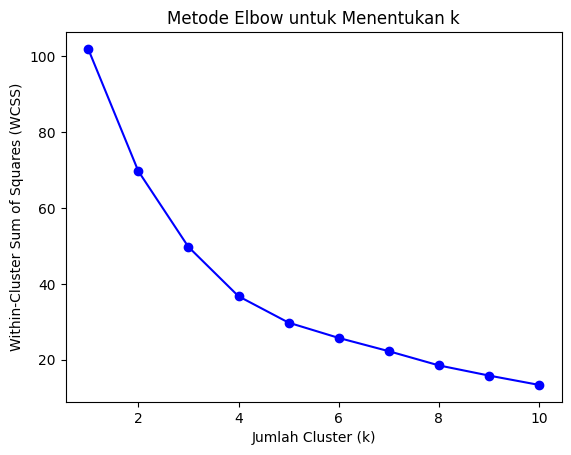

In [4]:
wcss = []
K = range(1, 11)  # coba dari 1 sampai 10 cluster
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia = jumlah jarak kuadrat dalam cluster

# Visualisasi Elbow
plt.plot(K, wcss, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Metode Elbow untuk Menentukan k')
plt.show()

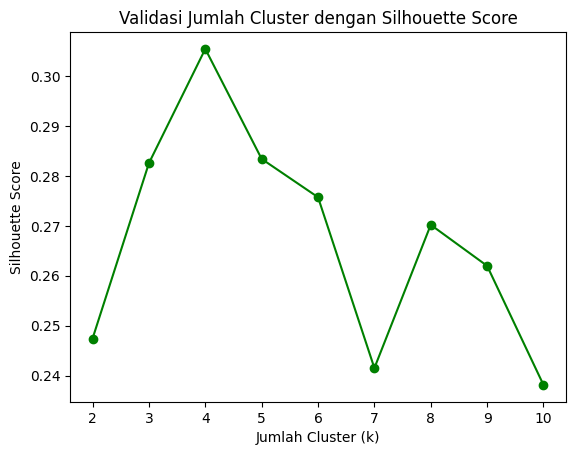

In [5]:
silhouette_scores = []
K_range = range(2, 11)  # silhouette tidak didefinisikan untuk k=1
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Score
plt.plot(K_range, silhouette_scores, 'go-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Validasi Jumlah Cluster dengan Silhouette Score')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(X_scaled)
data

,Provinsi,Upah Minimum Regional/Propinsi (Rupiah),Persentase Rumah Tangga yang Memiliki Akses Terhadap Hunian Yang Layak Menurut Provinsi (Persen),AHH,Cluster
0,ACEH,3165031,63.21,69.975,3
1,SUMATERA UTARA,2499423,67.44,69.150,2
2,SUMATERA BARAT,2484041,56.87,69.520,2
3,RIAU,2888564,68.44,71.650,3
4,JAMBI,2630162,61.41,71.170,3
5,SUMATERA SELATAN,3043111,55.25,69.930,2
6,BENGKULU,2213604,47.94,69.370,2
7,LAMPUNG,2432002,53.22,70.695,2
8,KEP. BANGKA BELITUNG,3230024,30.64,70.680,0
9,KEP. RIAU,3005460,48.19,69.990,2


In [7]:
# data.to_excel("C:/Users/AS/Downloads/klasterArsen.xlsx", index=False)

In [8]:
cluster_summary = (
    data.groupby('Cluster')
      .agg({
          'Persentase Rumah Tangga yang Memiliki Akses Terhadap Hunian Yang Layak Menurut Provinsi (Persen)': 'mean',
          'Upah Minimum Regional/Propinsi (Rupiah)': 'mean',
          'AHH': 'mean'
      })
      .round(2)  # pembulatan 2 angka di belakang koma
)

# Tampilkan hasil
cluster_summary

,Persentase Rumah Tangga yang Memiliki Akses Terhadap Hunian Yang Layak Menurut Provinsi (Persen),Upah Minimum Regional/Propinsi (Rupiah),AHH
Cluster,,,
0,30.79,3674358.00,69.82
1,68.62,1756437.75,73.48
2,55.43,2593628.06,68.55
3,67.57,2902942.00,71.73
